# Metody Obliczeniowe w Nauce i Technice
# Laboratorium 9: Zastosowania DFT
## Przemysław Roman

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from PIL import Image, ImageOps, ImageFont, ImageDraw
from numpy.fft import *
import string
from dataclasses import dataclass
from collections import defaultdict

def time_exec(func, *args):
    start_time = time.time()
    result = func(*args)
    return result, time.time() - start_time

mpl.rcParams['axes.titlesize'] = 16

## Funkcje pomocnicze

In [2]:
def open_image(im_path):
    im = Image.open(im_path)
    w, h = im.size
    return im, w, h

def process_image(im):
    im_gray = ImageOps.grayscale(im)
    im_inv = ImageOps.invert(im_gray)
    im_swap = np.swapaxes(np.array(im_inv), 0, 1)
    return im_swap

def show_image(im, figsize, title):
    plt.figure(figsize=figsize)
    fig, axs = plt.subplots(1, 1, figsize=figsize)
    axs.imshow(im)
    axs.set_title(title)
    plt.imshow(im)
    plt.show()

## Zadanie 1 Analiza obrazów

- Wczytaj obraz przedstawiający tekst, dokonaj odwrócenia kolorów (czarne tło), a
następnie jego transformacji do domeny częstotliwościowej za pomocą DFT. Przed-
staw wartości fazy i modułu współczynników Fouriera (osobno).
- Wybierz przykładowego reprezentanta grupy - wytnij z dużego zdjęcia wzorzec
obiektu np. literę e lub charakterystyczny fragment ryby z ławicy (imcrop).
- Wykorzystując transformację Fouriera oblicz korelację między wybranym wzorcem,
a całym obrazem
- Przedstaw otrzymany obraz wyjściowy oraz punkty, w których wykryto wystąpie-
nie wzorca (nałóż je na obraz oryginalny).
- Znajdź liczbę wystąpień wzorca. Testy przeprowadź na dwóch zbiorach danych.

In [22]:
def show_steps(im_processed, pattern_processed, im_dft, figsize):
    def unswap(im): return np.swapaxes(np.array(im), 0, 1)

    im_processed = unswap(im_processed)
    pattern_processed = unswap(pattern_processed)
    im_dft = unswap(im_dft)

    fig, axs = plt.subplots(2, 2, figsize=figsize)
    axs[0][0].imshow(im_processed, cmap='gray')
    axs[0][0].set_title('Przetworzony obraz')
    axs[0][1].imshow(pattern_processed, cmap='gray')
    axs[0][1].set_title('Przetworzony wzorzec')
    axs[1][0].imshow(np.log(abs(im_dft)), cmap='gray')
    axs[1][0].set_title('Amplituda')
    axs[1,1].imshow(np.angle(im_dft), cmap='gray')
    axs[1,1].set_title('Faza')
    plt.show()

def match_pattern_within_image(im_path, pattern_path, min_match_perc=0.95, figsize=(13, 8),
                               match_color_offset=(100, -50, -50), show_steps_f=True,
                               additional_process_im=None, additional_process_pattern=None):
    im, W, H = open_image(im_path)
    im_processed = process_image(im)
    if additional_process_im is not None:
        im_processed = additional_process_im(im_processed)
    im_dft = fft2(im_processed)

    pattern, w, h = open_image(pattern_path)
    pattern_processed = process_image(pattern)
    if additional_process_pattern is not None:
        pattern_processed = additional_process_pattern(pattern_processed)

    C = np.real(ifft2(im_dft * fft2(np.rot90(pattern_processed, k=2), s=[W, H])))
    C_min_match = min_match_perc * (np.max(C) - np.min(C)) + np.min(C)

    im_full = im.load()
    matches = np.argwhere(C >= C_min_match)
    for x, y in matches:
        for dx in range(w):
            for dy in range(h):
                r, g, b = im_full[x-dx, y-dy]
                im_full[x-dx,y-dy] = tuple(np.array([r, g, b]) + np.array(match_color_offset))

    if show_steps_f:
        show_steps(im_processed, pattern_processed, im_dft, np.array(figsize)*0.75)

    show_image(im, figsize, f'Wystąpień wzorca: {len(matches)}')

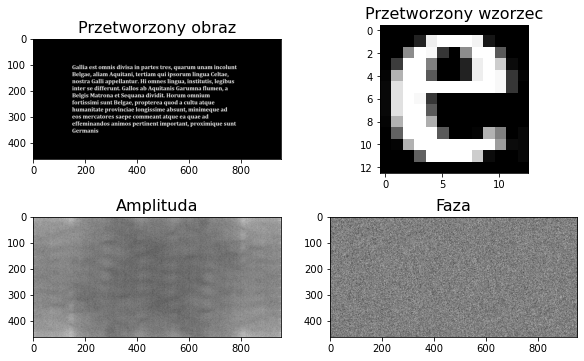

<Figure size 936x576 with 0 Axes>

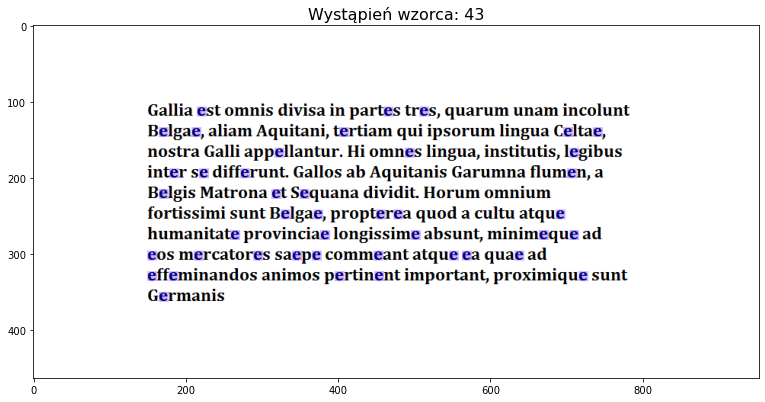

In [16]:
match_pattern_within_image(im_path='img/galia.png', pattern_path='img/galia_e.png', match_color_offset=(-50, -75, 100))

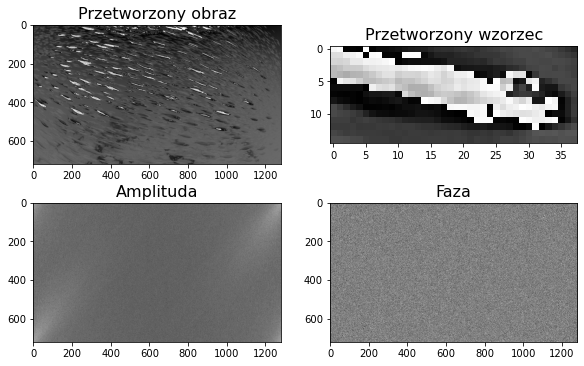

<Figure size 936x576 with 0 Axes>

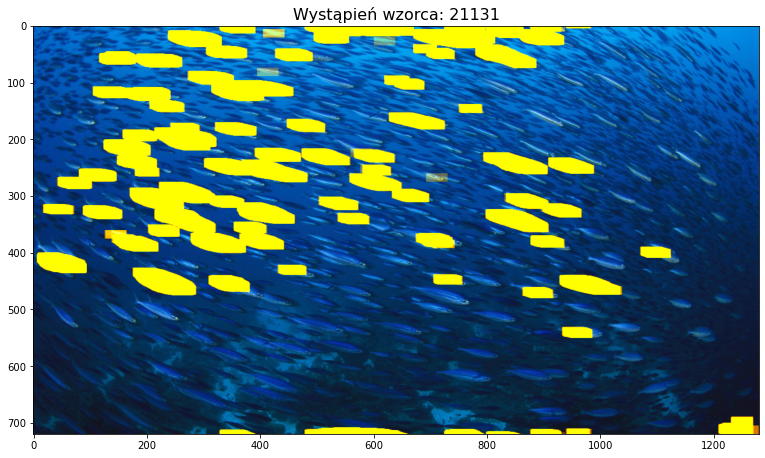

In [23]:
match_pattern_within_image(im_path='img/fish.jpg', pattern_path='img/fish1.png',
                           min_match_perc=0.5, match_color_offset=(100, 50, -50),
                           additional_process_im=lambda im: np.abs(np.array(im) - 130),
                           additional_process_pattern=lambda im: np.abs(np.array(im) - 130))

## Zadanie 2 OCR

Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr
2. Na obrazie występuje jeden typ i rozmiar czcionki
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe
4. W tekście występują znaki przestankowe: .,?!
5. Tekst składa się z wielu linii
6. Tekst może być obrócony (krzywo zeskanowany w całości)
7. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii
8. Program może raportować procent poprawnie rozpoznanych liter dla pre-definiowanych
obrazów testowych
9. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery
10. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja)
11. Należy dokonać redukcji szumu na obrazie wejściowym

In [6]:
def text_to_image(text, font_name, im_size, save_path_base):
    out = Image.new('RGB', im_size, (255, 255, 255))
    font_size = 1
    font = ImageFont.truetype(font_name, font_size)

    d = ImageDraw.Draw(out)

    while np.all(np.array(d.textsize(text, font)) < im_size):
        font_size += 1
        font = ImageFont.truetype(font_name, font_size)

    font_size -= 1
    font = ImageFont.truetype(font_name, font_size)
    d.multiline_text((0, 0), text, font=font, fill=(0, 0, 0))

    out.save(f'{save_path_base}_{font_size}.png')

lorem_ipsum = ''
with open('lorem_ipsum.txt', 'r') as f:
    lorem_ipsum = f.read()

text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.2)], 'FreeSerif.ttf', (400, 50), 'img/FreeSerif_short')
text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.5)], 'FreeSerif.ttf', (500, 160), 'img/FreeSerif_medium')
text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*1.0)], 'FreeSerif.ttf', (700, 350), 'img/FreeSerif_long')

text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.2)], 'FreeSans.ttf', (400, 50), 'img/FreeSans_short')
text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.5)], 'FreeSans.ttf', (500, 160), 'img/FreeSans_medium')
text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*1.0)], 'FreeSans.ttf', (700, 350), 'img/FreeSans_long')